In [1]:
import pandas as pd 
import numpy as np 

In [2]:
df = pd.read_csv('spambase_augmented.csv')


In [3]:
df.shape

(4600, 1186)

In [4]:
df.head()

,0.000,0.640,0.640.1,0.000.1,0.320,0.000.2,0.000.3,0.000.4,0.000.5,0.000.6,...,0.000.816,0.000.817,0.000.818,0.000.819,0.000.820,0.000.821,0.000.822,0.000.823,0.000.824,1
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.06,0.0,0.0,0.12,0.06,0.06,0.06,0.06,0.0,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,1


In [5]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [6]:
print(X.shape)
print(y.shape)

(4600, 1185)
(4600,)


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42) 

In [9]:
print('X train shape ', X_train.shape)
print('X test shape ', X_test.shape)

print('y train shape ', y_train.shape)
print('y test shape ', y_test.shape)

X train shape  (3680, 1185)
X test shape  (920, 1185)
y train shape  (3680,)
y test shape  (920,)


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [12]:
dt = DecisionTreeClassifier(random_state=0,criterion='entropy')

In [13]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [14]:
y_pred = dt.predict(X_test)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.92


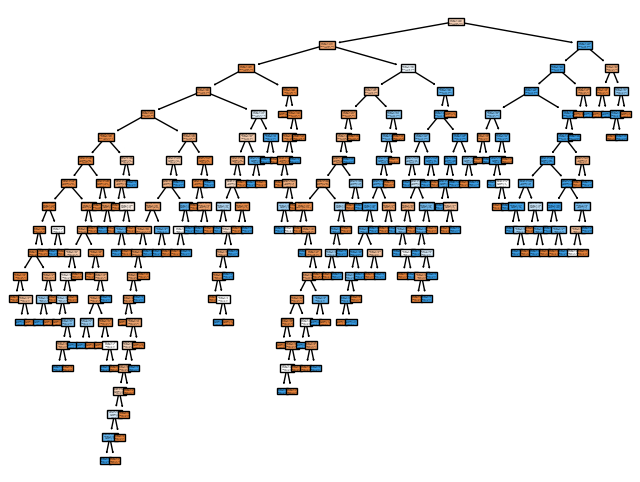

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plot_tree(dt, feature_names=X.columns, class_names=['0', '1'], filled=True)
plt.show()

In [17]:
from sklearn.metrics import classification_report, roc_auc_score
# Print Precision, Recall, and F1-score
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       530
           1       0.90      0.90      0.90       390

    accuracy                           0.92       920
   macro avg       0.91      0.91      0.91       920
weighted avg       0.92      0.92      0.92       920



In [18]:
# If y_pred contains class labels (0/1), you need probability estimates for AUC
y_prob = dt.predict_proba(X_test)[:, 1]  # Probabilities of the positive class (1)

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_auc:.2f}')


ROC-AUC Score: 0.92
